<a href="https://colab.research.google.com/github/AlpacaJake/OpenProject/blob/master/RANSAC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

RANSAC

In [0]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt


- N 반복횟수 최적화 (inlier 비율을 알고 있을때)

    N : 반복횟수

    m : 한번에 뽑는 sample 수

    a : observation들 중 inlier 의 비율

- N 번중 적어도 한번은 inlier 에서만 뽑힐 확률 p 

    p = 1 -(1 - a^m]^N

    N = log(1 - p) / log(1 - a^m)

- RANSAC 성공할 확률 p 가 99.9% 이면 p = 0.999

    a 는 20% 의 noise 를 주었으므로 0.8

    m 은 세개씩 sample 을 뽑았으므로 3

- N = log(1 - 0.999) / log(1 - 0.8^3) = 9.6283  으로 10 회 반복하면 된다.

10


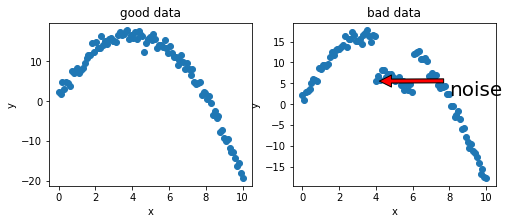

In [71]:
a_true = -1
b_true = 8
c_true =1
num_samples = 100

success_p = 0.999 # RANSAC 성공 확률  99.9%
observation_inlier = 0.8  # observation 중 inlier 의 비율 (bad data 가 20% 이므로 0.8)
onetime_sample_num = 3.0   # 한번에 뽑는 sample 수

trial_N = np.log(1-success_p) / np.log(1- pow(observation_inlier, onetime_sample_num))
trial_N = np.int(np.around(trial_N)) # 반올림 정수
print(trial_N)

def good_data(sigma=1, num_samples=100):
  x = np.linspace(0.0, 10.0, num=num_samples)
  y = a_true * x * x + b_true * x + c_true + np.random.normal(0, sigma, num_samples)
  return x, y

def bad_data(sigma=1, num_samples=100):
  x = np.linspace(0.0, 10.0, num_samples)
  #noise 생성
  noise = np.zeros(num_samples)
  x_left_idx = x > 4 
  x_right_idx = x < 6
  x_idx = x_left_idx & x_right_idx 
  noise[x_idx] = -10

  y = a_true *x *x + b_true *x + c_true + np.random.normal(0, sigma, num_samples) + noise

  return x, y

x_good , y_good = good_data(num_samples = num_samples)
x_bad, y_bad = bad_data(num_samples = num_samples)

plt.figure(1, figsize=(8,3))
plt.subplot(121)

plt.scatter(x_good, y_good)
plt.title('good data')
plt.xlabel('x')
plt.ylabel('y')

plt.subplot(122)
plt.scatter(x_bad, y_bad)
plt.title('bad data')
#plt.annotate ('noise', fontsize=20, xy=(4, y_bad[int(num_samples/10)*4]), xytest=(8,2), arrowprops=dict(facecolor='red', shrink=0.05))
plt.annotate('noise',  # noise 낀 곳을 표시
             fontsize=20,
             xy=(4, y_bad[int(num_samples/10)*4]),
             xytext=(8, 2),
             arrowprops=dict(facecolor='red', shrink=0.05))

plt.xlabel('x')
plt.ylabel('y')

plt.show()

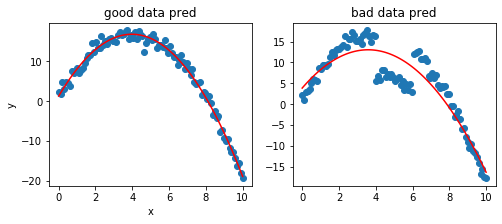

In [72]:
def get_y(x, a, b, c):
  return a*x*x + b*x + c

a1, b1, c1 = np.polyfit(x_good, y_good, 2)
y_good_pred = get_y(x_good, a1, b1, c1)

a2, b2, c2 = np.polyfit(x_bad, y_bad, 2)
y_bad_pred = get_y(x_bad, a2, b2, c2)

plt.figure(1, figsize=(8,3))
plt.subplot(121)

plt.scatter(x_good, y_good)
plt.plot(x_good, y_good_pred, 'r')
plt.title('good data pred')
plt.xlabel('x')
plt.ylabel('y')

plt.subplot(122)
plt.scatter(x_bad, y_bad)
plt.plot(x_bad, y_bad_pred, 'r')
plt.title('bad data pred')
plt.show()

1. max_inlier = 0으로 초기화한다.
2. 무작위로 세 점을 뽑는다.(parameter를 만들 때 필요한 최소 갯수의 observation)
3. 2에서 뽑은 점으로 model을 만든다 = parameter setting
4. 3에서 만든 모델에서 예측한 값과 일정 threshold안에 있는 inlier들의 갯수를 센다.
5. 4에서 센 갯수가 max_inlier보다 크면 max_inlier를 갱신하고, model을 저장한다.
6. 2~5를 N번 반복한 후 최종 저장된 model을 바노한한다.
7. (optional) 최종 inlier로 뽑힌 애들로 model을 refine한다.

In [0]:
def RANSAC(x, y, threshold = 0.3, N = trial_N):
  #(1) max_inlier = 0 으로 초기화 한다.
  max_inlier = 0
  a, b, c = 0, 0, 0
  inlier = None 

  #(6) 2 ~ 5 를 N 번 반복한 후 최종 저장된 model을 반환한다.
  for i in range(N):
    #(2) 무작위로 세점을 뽑는다. (parameter를 만들때 필요한 최소 갯수의 observation)
    samples = np.random.uniform(0, num_samples, 3)
#    print('random samples: ', samples)
    # 세개의 random 값을 int 로 변환
    samples = [int(sample) for sample in samples]
#    print('int samples: ', samples)
    # Random한 세점에 대한 x 값과 y 값 
    x_sampled = x[samples]
    y_sampled = y[samples]
#    print('x_sampled: ', x_sampled)
#    print('y_sampled: ', y_sampled)

    #(3) 2에서 뽑은 점으로 model 을 만든다
    # x, y sampled 세점에 대한 2차 방정식의 세 개수 a*x*x + b*x + c
    a_tmp, b_tmp, c_tmp = np.polyfit(x_sampled, y_sampled, 2)
#    print(a_tmp, b_tmp, c_tmp)
    # 세개의 random sample 로 추측한 모델로 전체 x 에 대한 y prediction 을 구함
    y_pred = get_y(x, a_tmp, b_tmp, c_tmp)
#    print('y_pred: ', y_pred)

    #(4) 3에서 만든 모델에서 예측한 값과 일정 threshold 안에 있는 inlier 들의 갯수를 센다.
    # y prediction 과 y 의 차가 threshold 이하인 것들을 구함 [ture, false ... ]
    tmp_inlier = abs(y_pred - y) < threshold
#    print('x[tmp_inlier]: ', x[tmp_inlier])
    # true 인 점에 대한 x 값의 개수를 구함
    count_inlier = len(x[tmp_inlier])

    #(5) 4에서 센 갯수가 max_inlier보다 크면 max_inlier를 갱신하고, model을 저장한다.
    if count_inlier > max_inlier:
      # 기존 max_inlier 보다 큰값을 저장
      max_inlier = count_inlier
      inlier = tmp_inlier 
      # 2차 방정식의 세 개수를 저장
      a, b, c = a_tmp, b_tmp, c_tmp 
      print('max_inlier', max_inlier)
      
  
  #(7) (optional) 최종 inlier로 뽑힌 애들로 model을 refine한다
  a, b, c = np.polyfit(x[inlier], y[inlier], 2)
  print('a: ', a, 'b: ', b, 'c: ', c)
  # 가장 잘 추정하는 2차 방정식의 세 개수를 return
  return a, b, c



max_inlier 11
max_inlier 18
a:  -0.9980160031775618 b:  7.583520216056042 c:  3.0842930570673666
max_inlier 12
max_inlier 19
max_inlier 22
a:  -1.1781164390004362 b:  9.762953879211429 c:  -1.648635984376052


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RankWarning: Polyfit may be poorly conditioned
  


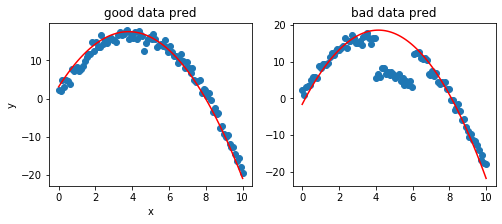

In [76]:
a_good, b_good, c_good = RANSAC(x_good, y_good)
a_bad, b_bad, c_bad = RANSAC(x_bad, y_bad)

y_good_pred = get_y(x_good, a_good, b_good, c_good)
y_bad_pred = get_y(x_bad, a_bad, b_bad, c_bad)

plt.figure(1, figsize=(8,3))
plt.subplot(121)

plt.scatter(x_good, y_good)
plt.plot(x_good, y_good_pred, 'r')
plt.title('good data pred')
plt.xlabel('x')
plt.ylabel('y')

plt.subplot(122)
plt.scatter(x_bad, y_bad)
plt.plot(x_bad, y_bad_pred, 'r')
plt.title('bad data pred')
plt.show()